# Projecting g membership obtained from one reference to another

The g membership is found by sorting the k-distribution at some reference (P, T).  We then look at how this g membership appears on a k-distribution at a different (P, T).

In [74]:
%matplotlib inline
from IPython import display
import os, sys

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib 
import matplotlib.pyplot as plt


In [75]:
matplotlib.rc('font', size=13)

# O3 band 5 absorption coefficient

In [3]:
# for loading absorption coefficient calculated using line-by-line
# k(v, pt)

def get_data_file_paths():
    
    dir_common = os.path.join('/nuwa_cluster/home/jackyu',
                              'radiation/crd/LW/examples',
                              'separate_g_groups',
                              'study__lblnew_g1_threshold',
                              'o3',
                              'wn_20_3000',
                              'absgas_variousPTs')
    
    dir_runs = ['T__250K_P__10_50_100_500_1e3',
                'T__250K_P__.1_1_5mb']
    
    path_runs = [os.path.join(dir_common, dir_run, 'output_absgas.dat')
                 for dir_run in dir_runs]
    return path_runs



def load_absgas_file(path_absgas):
    df = pd.read_csv(path_absgas, sep=r'\s+')
    df = df.set_index(['v', 'pressure', 'temperature'])
    
    ds = xr.Dataset.from_dataframe(df)
    ds = ds.stack(pt=('pressure', 'temperature'))
    ds.coords['ipt'] = ('pt', range(1, ds.dims['pt'] + 1))
    return ds   
    

    
def load_absgas_files(paths_absgas):
    dss = [load_absgas_file(fpath) for fpath in paths_absgas]
    return xr.concat(dss, dim='pt')



def o3_band5_limits():
    return {'min': 980, 'max': 1100}



def ref_pts():
    return {'low': (50, 250), 'high': (1, 250)}




def get_tworef_dataframe(ds, min_wvn=0, max_wvn=3000, pts=None):
    if pts == None:
        pts = [(50, 250)]
        
    pts = sorted([pt for _, pt in ref_pts().items()],
                 key=lambda x: x[0])
    return ds['absgas'].sel(pt=pts, v=slice(min_wvn, max_wvn))\
           .to_pandas()


In [4]:
ds = load_absgas_files(get_data_file_paths())

In [5]:
vlims = o3_band5_limits()
pts = [pt for _, pt in ref_pts().items()]

df = get_tworef_dataframe(ds, 
                          min_wvn=vlims['min'],
                          max_wvn=vlims['max'],
                          pts=pts)

In [6]:
df.head()

pressure,1,50
temperature,250,250
v,,
980.001,1.852463e-20,5.806543e-21
980.003,3.134201e-22,4.071877e-21
980.005,8.245442e-23,2.557286e-21
980.007,4.312231e-23,1.698846e-21
980.009,2.852815e-23,1.243706e-21


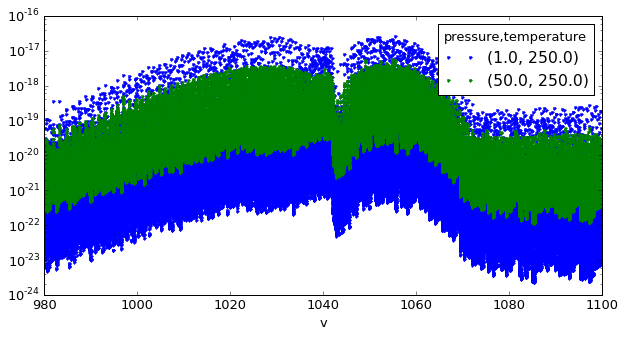

In [6]:
# have a look at the k at the two reference pt's.
df.plot(logy=True, figsize=(10, 5),
        linestyle='None', marker='.')

# Sorting k

In [7]:
def value_bins(absth):
    return np.concatenate(([0], absth[1:-1], [1]), axis=0)



def g_high_inclusive():
    "the lowest g that is from sorting k at pt_high"
    return 7


def ng_tot():
    return 20



def find_ggroup_membership(kdist, absth):
    '''
    Map each spectral point (or wavenumber) to a g-group,
    based on the distribution of k and the g-groups, defined
    by their upper and lower limits.
    '''
    bins = value_bins(absth)
    ng = len(absth) - 1

    return pd.cut(kdist, bins=bins, 
                  labels=range(1, ng + 1), 
                  include_lowest=True,
                  retbins=True)

In [51]:
def plt_membership(df, ncut_high):
    ng = ng_tot()
    
    kdist = {reflev: df[pt] for reflev, pt in ref_pts().items()}
    for reflev, srs in kdist.items():
        print(reflev)
        print(srs)
        print()
    
    fig, axs = plt.subplots(nrows=ng, ncols=2, figsize=(17, 5 * ng),
                            )
    

    
    for (ax_l, ax_h), g in zip(axs, range(1, 3 + 1)):
        

        
        ax_h.plot(kdist['high'].index.values, 
                  kdist['high'].values,
                  linestyle='None', 
                  marker='.', markersize=.2,
                  color='grey')        
        
        ax_l.plot(kdist['low'].index.values, 
                  kdist['low'].values,
                  linestyle='None', 
                  marker='.', markersize=.2,
                  color='grey')

#        wvns_g = ncut_high[0][ncut_high[0] == g].index
            
#        ax_h.plot(kdist['high'][wvns_g].index.values, 
#                  kdist['high'][wvns_g].values, 
#                  linestyle='None', 
#                  marker='.', markersize=.2,
#                  color='r')        
#        ax_h.axhline(y=kdist['high'][wvns_g].values.min(), color='r')
#        ax_h.axhline(y=kdist['high'][wvns_g].values.max(), color='r')        
        

        
#        ax_l.plot(kdist['low'][wvns_g].index.values, 
#                  kdist['low'][wvns_g].values,
#                  linestyle='None', 
#                  marker='.', markersize=.2,
#                  color='r')        
#        ax_l.axhline(y=kdist['low'][wvns_g].values.min(), color='r')
#        ax_l.axhline(y=kdist['low'][wvns_g].values.max(), color='r')

    axs.flatten()[0].get_shared_y_axes().join(*axs.flatten())
    [ax.set_yscale('log') for ax in axs.flatten()]
        

    
    
    return fig, axs

In [9]:
srs = df[ref_pts()['high']]

absth_high = np.logspace(np.log10(srs.min()), 
                         np.log10(srs.max()), 
                         ng_tot() + 1)

ncut_high = find_ggroup_membership(srs, absth_high)

In [ ]:
1

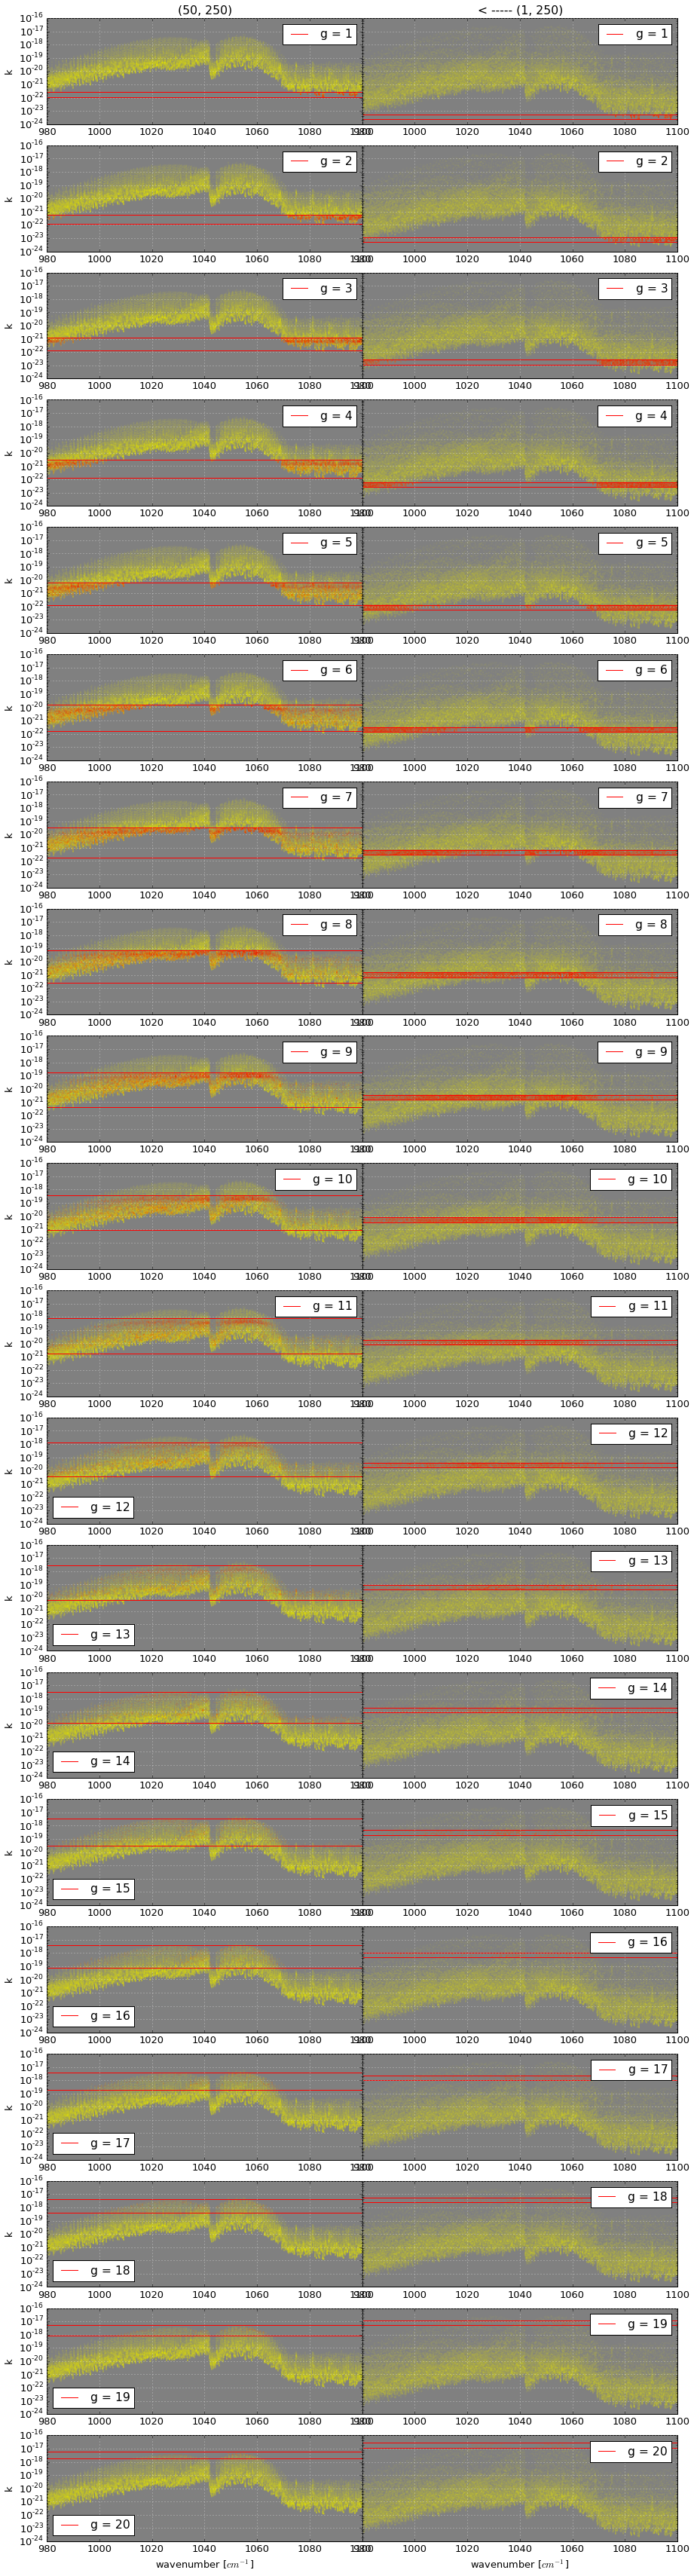

In [100]:
srs_l = df[ref_pts()['low']]
srs_h = df[ref_pts()['high']]




ng = 20

fig, axs = plt.subplots(nrows=ng, ncols=2, figsize=(15, 3 * ng),
                        )

for (ax_l, ax_h), g in zip(axs, range(1, ng + 1)):
    
    
    wvns_sub = ncut_high[0][ncut_high[0] == g].index
    
    ax_h.plot(srs_h.index,
             srs_h.values,
             color='yellow',
             linestyle='None', 
             marker='.', markersize=.2,
             alpha=.6)
    
    ax_h.plot(srs_h[wvns_sub].index,
              srs_h[wvns_sub].values, 
              color='red',
              linestyle='None', 
              marker='.', markersize=.2)
    
    ax_h.axhline(y=srs_h[wvns_sub].min(), 
                 color='red')
    ax_h.axhline(y=srs_h[wvns_sub].max(),
                 color='red',
                 label='g = {}'.format(g))
    
    ax_h.yaxis.set_tick_params(size=0)
    plt.setp(ax_h.get_yticklabels(), visible=False)
    
    ax_l.plot(srs_l.index,
             srs_l.values, 
             color='yellow',
             linestyle='None',
             marker='.', markersize=.2,
             alpha=.6)
    
    ax_l.plot(srs_l[wvns_sub].index,
              srs_l[wvns_sub].values,
              color='red',
              linestyle='None',
              marker='.', markersize=.2)
    
    ax_l.axhline(y=srs_l[wvns_sub].min(),
                 color='red')
    ax_l.axhline(y=srs_l[wvns_sub].max(),
                 color='red',
                 label='g = {}'.format(g))
    
    ax_l.set_ylabel('k')
    

axs.flatten()[0].get_shared_y_axes().join(*axs.flatten())

for ax in axs.flatten():
    ax.set_yscale('log')
    ax.legend(loc='best')
    ax.set_axis_bgcolor('grey')
    ax.grid(color='white')

for ax_l, ax_h in axs[:1]:
    ax_l.set_title('{}'.format(ref_pts()['low']))
    ax_h.set_title('< ----- {}'.format(ref_pts()['high']))
    
for ax_left, ax_right in axs[-1:]:
    ax_left.set_xlabel('wavenumber [$cm^{-1}$]')
    ax_right.set_xlabel('wavenumber [$cm^{-1}$]')

plt.subplots_adjust(wspace=0)

low
v
980.001     5.806543e-21
980.003     4.071877e-21
980.005     2.557286e-21
980.007     1.698846e-21
980.009     1.243706e-21
980.011     1.003223e-21
980.013     8.888812e-22
980.015     8.680233e-22
980.017     9.437726e-22
980.019     1.140802e-21
980.021     1.420162e-21
980.023     1.526241e-21
980.025     1.341251e-21
980.027     1.159936e-21
980.029     1.126002e-21
980.031     1.238594e-21
980.033     1.517394e-21
980.035     2.046534e-21
980.037     2.985338e-21
980.039     4.377791e-21
980.041     5.499331e-21
980.043     5.810329e-21
980.045     6.462410e-21
980.047     7.742919e-21
980.049     7.348024e-21
980.051     5.126898e-21
980.053     3.417111e-21
980.055     2.616010e-21
980.057     2.468378e-21
980.059     2.869001e-21
                ...     
1099.941    1.172786e-21
1099.943    1.289527e-21
1099.945    1.630671e-21
1099.947    2.128325e-21
1099.949    2.213337e-21
1099.951    1.677716e-21
1099.953    1.139091e-21
1099.955    8.135109e-22
1099.957    6.28982

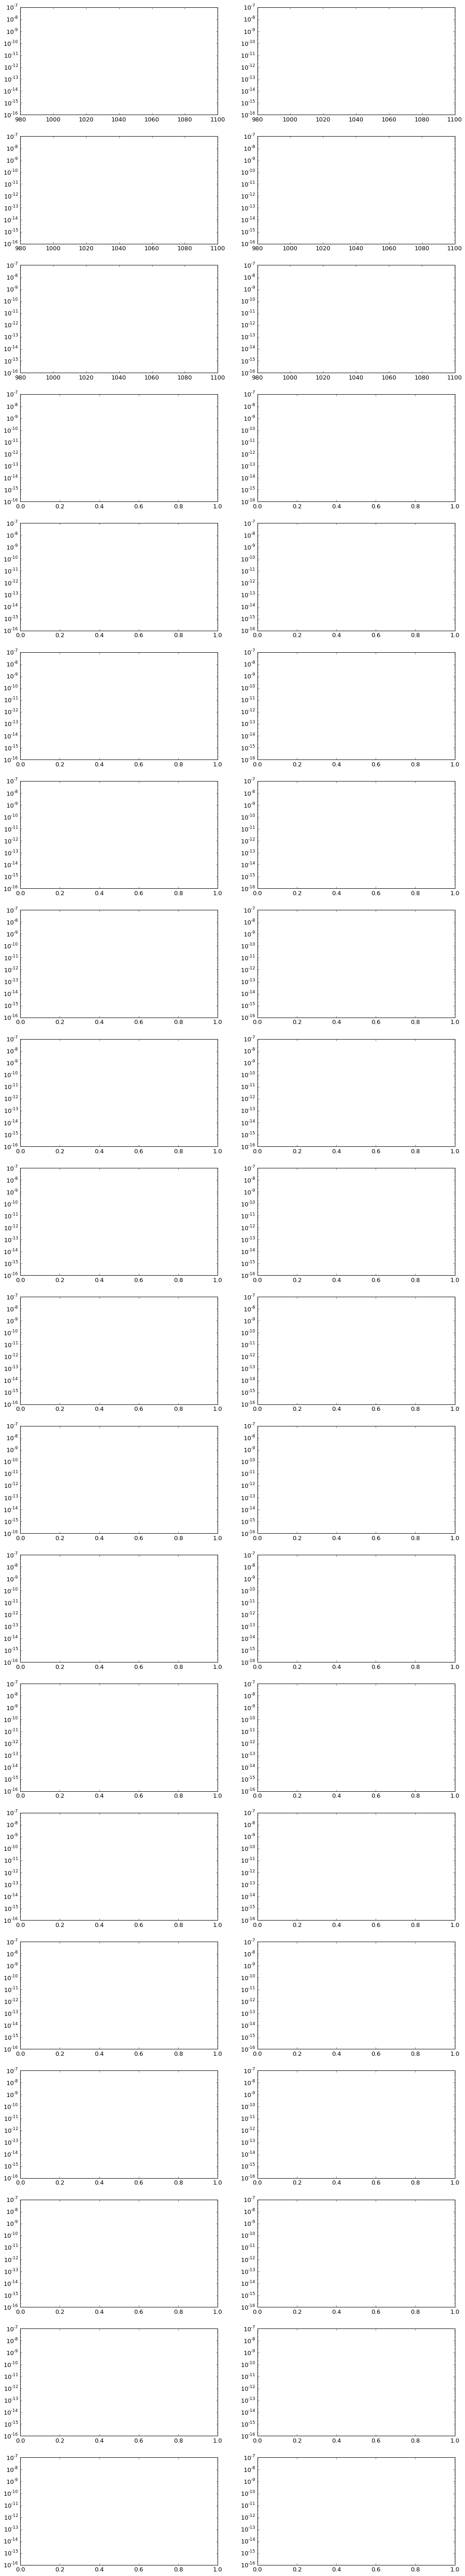

In [70]:
fig, axs = plt_membership(df, ncut_high)